In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "drive/My Drive/archive.zip" -d "content"

Archive:  drive/My Drive/archive.zip
replace content/Google_Stock_Price_Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace content/Google_Stock_Price_Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df_train = pd.read_csv("/content/content/Google_Stock_Price_Train.csv", index_col="Date",parse_dates=True)
df_test = pd.read_csv("/content/content/Google_Stock_Price_Test.csv", index_col="Date",parse_dates=True)

In [ ]:
df_train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
df_test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


In [ ]:
print("Training shape : ",df_train.shape)
print("Testing shape : ",df_test.shape)

Training shape :  (1258, 5)
Testing shape :  (20, 5)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


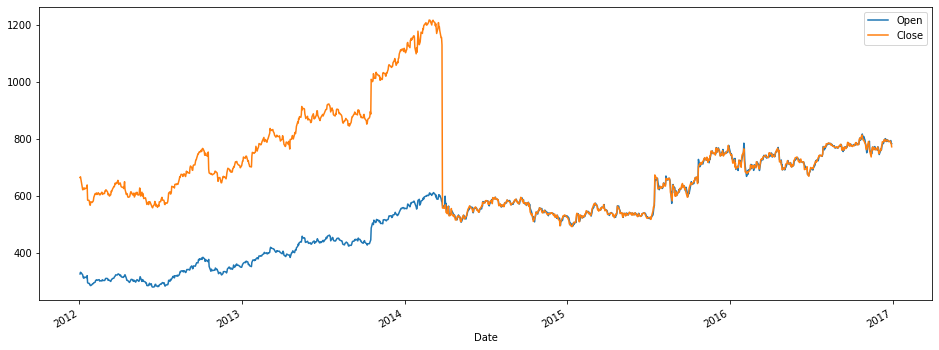

In [ ]:
df_train['Close'] = df_train['Close'].str.replace(',','').astype(float)
df_train[['Open','Close']].plot(figsize = (16,6))

In [ ]:
open_train = df_train['Open'].values.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
open_train_scaled = min_max.fit_transform(open_train)


In [ ]:
#defining timeset
X_train = []
y_train = []

#we will create a list that will store the previous data and predict a new output
#lets define the timestep as 70, i.e we will consider 54 Previous values and output will be 55th dataset
timestep = 70
for i in range(timestep,open_train_scaled.shape[0]):
    X_train.append(open_train_scaled[i-timestep:i, 0])
    y_train.append(open_train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM


In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 14s 154ms/step - loss: 0.0562
Epoch 2/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0064
Epoch 3/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0057
Epoch 4/100
38/38 [==============================] - 6s 156ms/step - loss: 0.0059
Epoch 5/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0052
Epoch 6/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0059
Epoch 7/100
38/38 [==============================] - 6s 157ms/step - loss: 0.0043
Epoch 8/100
38/38 [==============================] - 6s 155ms/step - loss: 0.0052
Epoch 9/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 6s 157ms/step - loss: 0.0043
Epoch 12/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0040
Epoch 13/100

**19-01**

In [ ]:
test_train_combine = pd.concat((df_train['Open'], df_test['Open']), axis = 0)

In [ ]:
prior_data = test_train_combine[len(test_train_combine)-len(df_test)-timestep:].values.reshape(-1,1)
prior_data_scaled = min_max.transform(prior_data)

X_test = []


for i in range(timestep,timestep + len(df_test['Open'])):
  X_test.append(prior_data_scaled[i-timestep:i,0])
  

X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_values = regressor.predict(X_test)

In [ ]:
unscaling_predicted_values = min_max.inverse_transform(predicted_values)
real_values = df_test['Open'].values

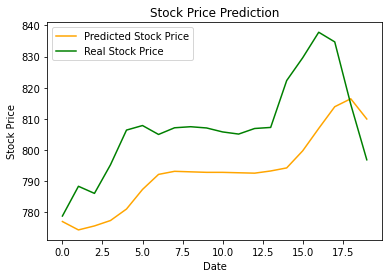

In [ ]:
plt.plot(unscaling_predicted_values,color = 'orange', label = 'Predicted Stock Price')
plt.plot(real_values,color = 'green', label = 'Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
unscaling_predicted_values

array([[777.0401 ],
       [774.3519 ],
       [775.63306],
       [777.36597],
       [781.0554 ],
       [787.34424],
       [792.1739 ],
       [793.16406],
       [792.99756],
       [792.8355 ],
       [792.8303 ],
       [792.69794],
       [792.573  ],
       [793.2721 ],
       [794.25714],
       [799.7462 ],
       [806.9306 ],
       [813.9009 ],
       [816.4574 ],
       [809.96185]], dtype=float32)

In [ ]:
X_test.shape

(20, 70, 1)